# Complementary material to self-study 1
Here are some Python snippets whose purpose is to help with the implementational aspects of self-study 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Data generation
First, here is how one can generate the problem's data:

In [2]:
def circle_2d(m,Lx,Ly,x0,y0,r,inside):
    """
    small circle inside big rectangle.
    inside=True => w=+1 inside small rectangle; -1 otherwise
    """

    x_min,y_min = -Lx/2,-Ly/2
    x_max,y_max =  Lx/2, Ly/2

    if inside:
        wi =  1.0
    else:
        wi = -1.0

    z = np.random.rand(m,2)
    z[:,0] = x_min + (x_max-x_min)*z[:,0]
    z[:,1] = y_min + (y_max-y_min)*z[:,1]
    it = np.nditer([z[:,0], z[:,1], None])
    for x,y,w in it:
        if (x-x0)**2 + (y-y0)**2 <= r**2 :
            w[...] =  wi
        else:
            w[...] = -wi
    w = it.operands[2]
    return z,w

In [3]:
def rectangle_2d(m,X0,Y0,Lx,Ly,x0,y0,lx,ly,inside):
    """
    small rectangle inside a big rectangle.
    inside=True => w=+1 inside small rectangle; -1 otherwise
    """

    x_min,y_min = X0,Y0
    x_max,y_max = X0+Lx,Y0+Ly

    if inside:
        wi =  1.0
    else:
        wi = -1.0

    z = np.random.rand(m,2)
    z[:,0] = x_min + Lx*z[:,0]
    z[:,1] = y_min + Ly*z[:,1]
    it = np.nditer([z[:,0], z[:,1], None])
    for x,y,w in it:
        if x>=x0 and x<=x0+lx and \
           y>=x0 and y<=y0+ly:
            w[...] =  wi
        else:
            w[...] = -wi
    w = it.operands[2]
    return z,w


## Data visualization:
Here is a small utility function that extracts the solution components and creates a matrix and vector from them:

In [4]:
def tomatvec(x,n):
    "convert optimization variables x to matrix-vector format"
    assert(n>0)
    n2= int(((n+1)*n)/2)
    assert(x.shape==(n2+n,))
    A = np.zeros((n,n))
    k = 0
    for i in range(n):
        for j in range(i,n):
            A[i,j] = x[k]
            A[j,i] = x[k]
            k += 1
    b = x[n2:]
    return A,b

And a visualization routine:

In [5]:
def visualize(x,z,w):
    """
    visualize everything
    """
    m = z.shape[0]
    n = z.shape[1]
    # vizualize ellipse
    A,b = tomatvec(x,n)
    ellipse_func = lambda z: z.dot(A.dot(z)) + b.dot(z) - 1.0
    #
    delta = 0.05
    xmin,xmax = np.min(z[:,0])-delta,np.max(z[:,0])+delta
    ymin,ymax = np.min(z[:,1])-delta,np.max(z[:,1])+delta
    #
    xx = np.arange(xmin, xmax, delta)
    yy = np.arange(ymin, ymax, delta)
    X, Y = np.meshgrid(xx, yy)
    it = np.nditer([X, Y, None])
    for xx,yy,zz in it:
        zz[...] = ellipse_func(np.array([xx,yy]))
    Z = it.operands[2]
    #
    zmin = np.min(Z)-0.1
    CS = plt.contourf(X, Y, Z, levels=[zmin,0.0],alpha=0.5,\
                                cmap=plt.cm.bone)
    CS = plt.contour(X, Y, Z,levels = [0.0],colors='k')
    # # vizualize data
    plt.scatter(z[:,0],z[:,1],s=5*np.ones_like(z[:,0]),c=w,marker='.',\
                cmap=plt.cm.seismic)
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.colorbar()
    plt.show()

Let us now generate some data, take an initial guess of sorts, and visualize the situation:

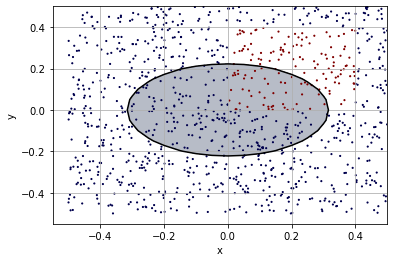

In [6]:
# number of points
m =1000
# generate some points which are labelled "1" inside a small rectangle with lower left corner (0,0) 
# and sides (0.4,0.4)
# all points are in a larger rectangle with ll corner (-0.5,-0.5) and sides (1.0,1.0)
z,w = rectangle_2d(m,-0.5,-0.5,1.0,1.0,0.,0.,0.4,0.4,True)
# we work in two dimensions
n = 2
n2= int(((n+1)*n)/2)
# total number of variables
N =n2+n
# initial guess
x0=np.zeros(N)
x0[[0,2]]=[10,20]

# and plot everything
visualize(x0,z,w)

Note, in the figure above red points are labelled with 1, blue points are labeled with -1, and the gray ellipsoid is the set $\hat{S}_{A,b}$ corresponding to our initial guess $x_0$

## Linesearches

In [7]:
def armijo_linesearch(f,df,x,p,alpha0,c1):
    alpha = alpha0
    rho = 0.5
    f0  = f(x)
    df0 = c1*df(x).dot(p)
    assert(df0 < 0)
    while f(x+alpha*p) > f0+alpha*df0:
        alpha = alpha*rho
    return alpha

In [8]:
# linesearch for satisfying weak Wolfe conditions
def bisection_linesearch(f,df,x,p,alpha0,c1,c2):
    alpha_min, alpha_max = 0.0, np.inf
    alpha = alpha0
    fx   = f(x)
    dfx  = df(x)
    dfxp = dfx.dot(p)
    assert(dfxp < 0)

    while alpha < 1.0E+10:
        #print(alpha,alpha_min,alpha_max)
        if np.abs(alpha_max-alpha_min)<1.0E-10:
            return alpha
        if f(x+alpha*p) > fx + alpha*c1*dfxp:
            # no sufficient decrease - too long step
            alpha_max = alpha
            alpha = 0.5*(alpha_max + alpha_min)
        elif df(x+alpha*p).dot(p) < c2*dfxp:
            # no curvature condition: too short step
            alpha_min = alpha
            if alpha_max == np.inf:
                alpha *= 2.0
            else:
                alpha = 0.5*(alpha_max + alpha_min)
        else:
            # we are done!
            return alpha
    raise ValueError('Steplength is way too long!')

In [9]:
def zoom(f,df,x,p,alpha_low,alpha_hi,c1,c2,fx,dfxp):
    tol = 1.0E-12
    while np.abs(alpha_hi-alpha_low) > tol:
        alpha  = 0.5*(alpha_low + alpha_hi)
        xalpha = x+alpha*p
        falpha = f(x+alpha*p)
        flo    = f(x+alpha_low*p)
        #fhi    = f(x+alpha_hi *p)
        if falpha > fx+c1*alpha*dfxp or falpha >= flo:
            alpha_hi = alpha
        else:
            dfalpha = df(x+alpha*p).dot(p)
            if np.abs(dfalpha) <= -c2*dfxp:
                return alpha
            if dfalpha*(alpha_hi-alpha_low) >= 0.0:
                alpha_hi = alpha_low
            alpha_low = alpha
    print("Warning: bisection did not converge")
    return 0.5*(alpha_low+alpha_hi)


# linesearch for satisfying strong Wolfe conditions
def swolfe_linesearch(f,df,x,p,alpha0,c1,c2):
    alpha_max = 1.0E+10
    alpha_cur = alpha0
    alpha_pre = 0.0
    Nmax = 1000

    fx   = f(x)
    dfx  = df(x)
    dfxp = dfx.dot(p)
    assert(dfxp < 0)

    falpha_pre = 0.0

    for i in range(Nmax):
        falpha_cur = f(x+alpha_cur*p)
        if falpha_cur>fx+alpha_cur*c1*dfxp or (i>1 and falpha_cur >= falpha_pre):
            return zoom(f,df,x,p,alpha_pre,alpha_cur,c1,c2,fx,dfxp)
        dfalpha = df(x+alpha_cur*p).dot(p)
        if np.abs(dfalpha) <= -c2*dfxp:
            return alpha_cur
        if dfalpha >= 0:
            return zoom(f,df,x,p,alpha_cur,alpha_pre,c1,c2,fx,dfxp)
        alpha_pre = alpha_cur
        falpha_pre=falpha_cur
        alpha_cur = 2.0*alpha_cur
        if alpha_cur >= alpha_max:
            break
    raise ValueError('Too many iterations in linesearch!')

## Just a test of linesearch implementation

In [10]:
from scipy.linalg import hilbert 

n = 5
A = hilbert(n)
b = np.zeros(n)

f = lambda x: 0.5*x.dot(A.dot(x))-b.dot(x)
df= lambda x: A.dot(x)-b

x = np.ones(n)
grad_norm = 1.0

c1 = 0.1
c2 = 0.3
k  = 0

while True:
    grad  = df(x)
    gradn = np.linalg.norm(grad)
    if gradn < 1.0E-06:
        print("Success!")
        break
    else:
        print("k = %5d, f(x) = %e, |df|=%e" % (k,f(x),gradn))
    p     = -grad
    #alpha = armijo_linesearch(f,df,x,p,1.0,c1)
    #alpha = bisection_linesearch(f,df,x,p,1.0,c1,c2)
    alpha = swolfe_linesearch(f,df,x,p,1.0,c1,c2)
    x    += alpha*p
    k    += 1

k =     0, f(x) = 3.228175e+00, |df|=3.138280e+00
k =     1, f(x) = 2.259942e-01, |df|=7.018285e-01
k =     2, f(x) = 7.059909e-02, |df|=2.190541e-01
k =     3, f(x) = 4.224644e-02, |df|=1.532806e-01
k =     4, f(x) = 2.386895e-02, |df|=1.928100e-01
k =     5, f(x) = 1.021827e-02, |df|=7.057831e-02
k =     6, f(x) = 4.963580e-03, |df|=7.603542e-02
k =     7, f(x) = 2.782403e-03, |df|=4.773135e-02
k =     8, f(x) = 1.705045e-03, |df|=3.157152e-02
k =     9, f(x) = 1.121562e-03, |df|=2.207926e-02
k =    10, f(x) = 7.461294e-04, |df|=2.806967e-02
k =    11, f(x) = 4.564244e-04, |df|=1.035704e-02
k =    12, f(x) = 3.401179e-04, |df|=1.125076e-02
k =    13, f(x) = 2.897112e-04, |df|=7.261854e-03
k =    14, f(x) = 2.623646e-04, |df|=5.077002e-03
k =    15, f(x) = 2.433457e-04, |df|=5.279219e-03
k =    16, f(x) = 2.298551e-04, |df|=3.726190e-03
k =    17, f(x) = 2.198393e-04, |df|=4.086961e-03
k =    18, f(x) = 2.114260e-04, |df|=3.001992e-03
k =    19, f(x) = 2.043288e-04, |df|=4.471861e-03


k =  1436, f(x) = 8.027670e-08, |df|=1.425458e-05
k =  1437, f(x) = 8.019429e-08, |df|=9.929337e-06
k =  1438, f(x) = 8.013453e-08, |df|=8.058363e-06
k =  1439, f(x) = 8.005463e-08, |df|=1.102361e-05
k =  1440, f(x) = 7.998999e-08, |df|=8.499929e-06
k =  1441, f(x) = 7.991866e-08, |df|=1.245550e-05
k =  1442, f(x) = 7.984681e-08, |df|=9.110330e-06
k =  1443, f(x) = 7.978796e-08, |df|=1.429737e-05
k =  1444, f(x) = 7.970551e-08, |df|=9.938901e-06
k =  1445, f(x) = 7.964595e-08, |df|=8.049569e-06
k =  1446, f(x) = 7.956682e-08, |df|=1.104255e-05
k =  1447, f(x) = 7.950232e-08, |df|=8.495924e-06
k =  1448, f(x) = 7.943185e-08, |df|=1.248561e-05
k =  1449, f(x) = 7.936007e-08, |df|=9.112495e-06
k =  1450, f(x) = 7.929638e-08, |df|=1.055625e-05
k =  1451, f(x) = 7.923428e-08, |df|=8.288099e-06
k =  1452, f(x) = 7.916037e-08, |df|=1.185685e-05
k =  1453, f(x) = 7.909203e-08, |df|=8.832074e-06
k =  1454, f(x) = 7.902895e-08, |df|=1.353941e-05
k =  1455, f(x) = 7.895143e-08, |df|=9.575244e-06


k =  2521, f(x) = 3.117506e-08, |df|=5.613220e-06
k =  2522, f(x) = 3.115110e-08, |df|=8.704614e-06
k =  2523, f(x) = 3.111980e-08, |df|=6.104098e-06
k =  2524, f(x) = 3.109683e-08, |df|=4.986910e-06
k =  2525, f(x) = 3.106550e-08, |df|=6.760139e-06
k =  2526, f(x) = 3.104074e-08, |df|=5.249697e-06
k =  2527, f(x) = 3.101256e-08, |df|=7.620689e-06
k =  2528, f(x) = 3.098514e-08, |df|=5.613822e-06
k =  2529, f(x) = 3.096156e-08, |df|=8.730080e-06
k =  2530, f(x) = 3.093025e-08, |df|=6.109345e-06
k =  2531, f(x) = 3.090736e-08, |df|=4.981090e-06
k =  2532, f(x) = 3.087632e-08, |df|=6.771072e-06
k =  2533, f(x) = 3.085162e-08, |df|=5.246752e-06
k =  2534, f(x) = 3.082377e-08, |df|=7.638425e-06
k =  2535, f(x) = 3.079639e-08, |df|=5.614595e-06
k =  2536, f(x) = 3.077318e-08, |df|=8.755827e-06
k =  2537, f(x) = 3.074186e-08, |df|=6.114791e-06
k =  2538, f(x) = 3.071905e-08, |df|=4.975391e-06
k =  2539, f(x) = 3.068830e-08, |df|=6.782232e-06
k =  2540, f(x) = 3.066366e-08, |df|=5.243952e-06


k =  3613, f(x) = 1.204746e-08, |df|=4.663985e-06
k =  3614, f(x) = 1.203700e-08, |df|=3.460392e-06
k =  3615, f(x) = 1.202757e-08, |df|=5.332000e-06
k =  3616, f(x) = 1.201567e-08, |df|=3.756633e-06
k =  3617, f(x) = 1.200687e-08, |df|=3.083079e-06
k =  3618, f(x) = 1.199470e-08, |df|=4.153256e-06
k =  3619, f(x) = 1.198524e-08, |df|=3.241147e-06
k =  3620, f(x) = 1.197425e-08, |df|=4.674412e-06
k =  3621, f(x) = 1.196380e-08, |df|=3.460526e-06
k =  3622, f(x) = 1.195451e-08, |df|=5.347309e-06
k =  3623, f(x) = 1.194261e-08, |df|=3.759593e-06
k =  3624, f(x) = 1.193385e-08, |df|=3.079322e-06
k =  3625, f(x) = 1.192179e-08, |df|=4.159682e-06
k =  3626, f(x) = 1.191235e-08, |df|=3.239130e-06
k =  3627, f(x) = 1.190148e-08, |df|=4.684994e-06
k =  3628, f(x) = 1.189104e-08, |df|=3.460765e-06
k =  3629, f(x) = 1.188190e-08, |df|=5.362791e-06
k =  3630, f(x) = 1.187000e-08, |df|=3.762674e-06
k =  3631, f(x) = 1.186126e-08, |df|=3.075639e-06
k =  3632, f(x) = 1.184932e-08, |df|=4.166248e-06


k =  4738, f(x) = 4.537373e-09, |df|=1.896902e-06
k =  4739, f(x) = 4.532822e-09, |df|=2.567665e-06
k =  4740, f(x) = 4.529239e-09, |df|=1.996230e-06
k =  4741, f(x) = 4.525142e-09, |df|=2.893447e-06
k =  4742, f(x) = 4.521179e-09, |df|=2.133914e-06
k =  4743, f(x) = 4.517742e-09, |df|=3.313583e-06
k =  4744, f(x) = 4.513218e-09, |df|=2.321358e-06
k =  4745, f(x) = 4.509905e-09, |df|=1.894666e-06
k =  4746, f(x) = 4.505397e-09, |df|=2.571776e-06
k =  4747, f(x) = 4.501823e-09, |df|=1.995082e-06
k =  4748, f(x) = 4.497774e-09, |df|=2.900139e-06
k =  4749, f(x) = 4.493815e-09, |df|=2.134174e-06
k =  4750, f(x) = 4.490432e-09, |df|=3.323315e-06
k =  4751, f(x) = 4.485907e-09, |df|=2.323389e-06
k =  4752, f(x) = 4.482605e-09, |df|=1.892475e-06
k =  4753, f(x) = 4.478140e-09, |df|=2.575974e-06
k =  4754, f(x) = 4.474575e-09, |df|=1.993989e-06
k =  4755, f(x) = 4.470572e-09, |df|=2.906927e-06
k =  4756, f(x) = 4.466618e-09, |df|=2.134500e-06
k =  4757, f(x) = 4.463289e-09, |df|=3.333154e-06


k =  5719, f(x) = 1.947600e-09, |df|=1.685563e-06
k =  5720, f(x) = 1.946068e-09, |df|=1.306479e-06
k =  5721, f(x) = 1.944339e-09, |df|=1.901301e-06
k =  5722, f(x) = 1.942641e-09, |df|=1.397946e-06
k =  5723, f(x) = 1.941199e-09, |df|=2.179259e-06
k =  5724, f(x) = 1.939257e-09, |df|=1.522336e-06
k =  5725, f(x) = 1.937843e-09, |df|=1.239004e-06
k =  5726, f(x) = 1.935934e-09, |df|=1.688334e-06
k =  5727, f(x) = 1.934406e-09, |df|=1.305778e-06
k =  5728, f(x) = 1.932697e-09, |df|=1.905772e-06
k =  5729, f(x) = 1.931001e-09, |df|=1.398176e-06
k =  5730, f(x) = 1.929582e-09, |df|=2.185732e-06
k =  5731, f(x) = 1.927640e-09, |df|=1.523735e-06
k =  5732, f(x) = 1.926230e-09, |df|=1.237612e-06
k =  5733, f(x) = 1.924340e-09, |df|=1.691162e-06
k =  5734, f(x) = 1.922815e-09, |df|=1.305112e-06
k =  5735, f(x) = 1.921126e-09, |df|=1.910307e-06
k =  5736, f(x) = 1.919432e-09, |df|=1.398449e-06
k =  5737, f(x) = 1.918036e-09, |df|=2.192274e-06
k =  5738, f(x) = 1.916093e-09, |df|=1.525185e-06
